# Auswertung des (zeitlichen) Nutzungsverhalten

In [1]:
import datetime as dt
import os
import re
import src.project_definitions as eb

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages

from src import style, graphs
style.set_rc_eb_standard()

### Import update_databases um die Datenbank zu aktualisieren wenn sie heute noch nicht aktualisiert wurde....
#from src import update_databases

import src.project_definitions as eb
import src.utilities as ut
import src.sensor_reader as sr

import locale
locale.setlocale(locale.LC_ALL,'de_DE')

### ACHTUNG: Diese Zeilen nur aktivieren wenn Sicher ist, dass der Code funktioniert.
import warnings
warnings.filterwarnings('ignore')

#### Messdaten Import
startdate = '2021-06-01'
IND = {bui: sr.load_tf_bui(bui,'1min').loc[startdate:] for bui in eb.buid}
#IND = pd.concat(IND,axis=1)
KOMPASS = {'n': 'Nord', 'o':'Ost', 's': 'Süd', 'w': 'West'}


In [37]:
##### USER INPUTS #####
ex = True

## Vergleich der Tagesverläufe der Sensoren
___

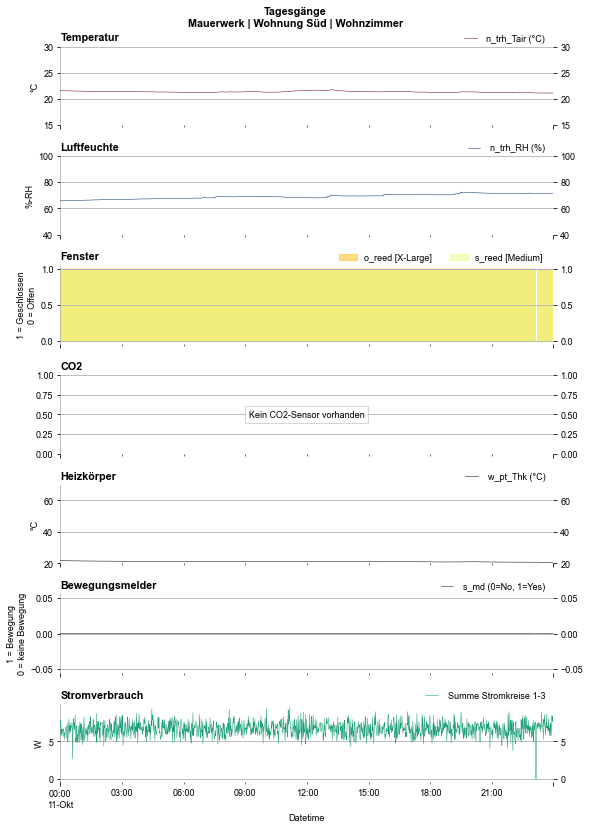

In [38]:
bui = 'MW'

app = 'S'       # 'N' = Nord, 'S' = Süd, 'O' = Ost

room = 'WZ'     # 'WZ', 'SZ', 'F', 'K': Nord, Süd; 'B': Alle; 'SWK': nur Ost

date = '2021-10-11'

fig, axs = plt.subplots(7,1, figsize=style.din_a4, sharex=True)

mpl.style.use('./src/stylesheets/DailyApp.mplstyle')
fig.suptitle(f'Tagesgänge\n{eb.buid[bui]} | Wohnung {eb.wohnungen[app]} | {eb.rooms[room]}', fontweight = 'bold')

ax = axs[0]
ax.set_title('Temperatur')
IND[bui][app][room].loc[date].filter(like='_trh_Tair').plot(ax=ax,cmap='Reds_r')
ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
ax.set_ylim(15, 30)
ax.set_ylabel('°C')

ax = axs[1]
ax.set_title('Luftfeuchte')
IND[bui][app][room].loc[date].filter(like='_trh_RH').plot(ax=ax,cmap='Blues_r',label = ['Raumluftfeuchte'])
ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
ax.set_ylim(40, 100)
ax.set_ylabel('%-RH')

ax = axs[2]
ax.set_title('Fenster')
try:
    windows = IND[bui][app][room].loc[date].filter(like='reed ').replace(['Closed', 'Open'], [1,0])
    windows.plot(ax=ax, cmap='Purples_r',label=[f'{col.split("_")[0]}-Fassade, Fenster: {col.split("[")[1].replace("]","")}' for col in windows.columns])
    for w,col in enumerate(windows.columns):
        norm = mpl.colors.Normalize(vmin=0, vmax=len(windows.columns))
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Wistia_r)
        cmap.set_array([])
        label = f'{col.split("_")[0]}-Fassade, Fenster: {col.split("[")[1].replace("]","")}'
        
        ax.fill_between(x=windows[col].index, y1=windows[col], label=label, color=cmap.to_rgba(w + 1), alpha=0.5)
    han, lab = ax.get_legend_handles_labels()
    ax.legend(labels = list(set(lab)) , handles=[x for x in han if isinstance(x, mpl.collections.PolyCollection)], loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)

    ax.set_ylabel('1 = Geschlossen\n0 = Offen')
except Exception as e:
    ax.text(0.5,0.5,'Kein Fenster vorhanden',
                style='normal', 
                ha = 'center', 
                va = 'center',
                transform=ax.transAxes,
                bbox=style.eb_bbox, 
                )
    print(e)

ax = axs[3]
ax.set_title('CO2')
try:
    IND[bui][app][room].loc[date].filter(like='_co2 ').plot(ax=ax,cmap='Greens_r')
    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    ax.set_ylim(0,3000)
    ax.set_ylabel('ppm')
except:
    ax.text(0.5,0.5,'Kein CO2-Sensor vorhanden',
                style='normal', 
                ha = 'center', 
                va = 'center',
                transform=ax.transAxes,
                bbox=style.eb_bbox, 
                )
    pass

ax = axs[4]
ax.set_title('Heizkörper')
try:
    IND[bui][app][room].loc[date].filter(like='pt_Thk ').plot(ax=ax,cmap='Greys_r', label = 'Oberflächentemperatur')
    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    if bui in ['LB', 'MH']:
        ax.set_ylim(20, 50)
    if bui == 'MW':
        ax.set_ylim(20, 70)
    ax.set_ylabel('°C')
except:
    ax.text(0.5,0.5,'Keine Heizkörpertemperatur vorhanden',
                style='normal', 
                ha = 'center', 
                va = 'center',
                transform=ax.transAxes,
                bbox=style.eb_bbox, 
                )
    pass

ax = axs[5]
ax.set_title('Bewegungsmelder')
try:
    IND[bui][app][room].loc[date].filter(like='_md ').plot(ax=ax,cmap='Greys_r')
    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    ax.set_ylabel('1 = Bewegung\n0 = keine Bewegung')
except:
    ax.text(0.5,0.5,'Kein Bewegungsmelder vorhanden',
                style='normal', 
                ha = 'center', 
                va = 'center',
                transform=ax.transAxes,
                bbox=style.eb_bbox, 
                )
    pass

ax = axs[6]
IND[bui][app][''].loc[date].filter(like='(W)').sum(axis=1).plot(ax=ax,cmap='Dark2', label = 'Summe Stromkreise 1-3') #.sum(axis=1)
ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
ax.set_title('Stromverbrauch')
#ax.set_ylim(0, 2500)
ax.set_ylabel('W')
fig.tight_layout()

Text(0.0, 1.0, 'MW | S')

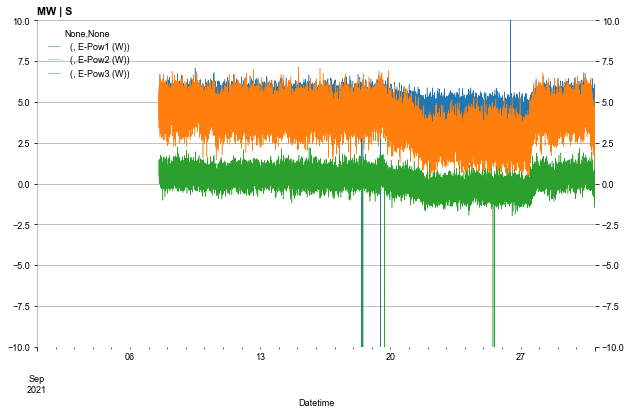

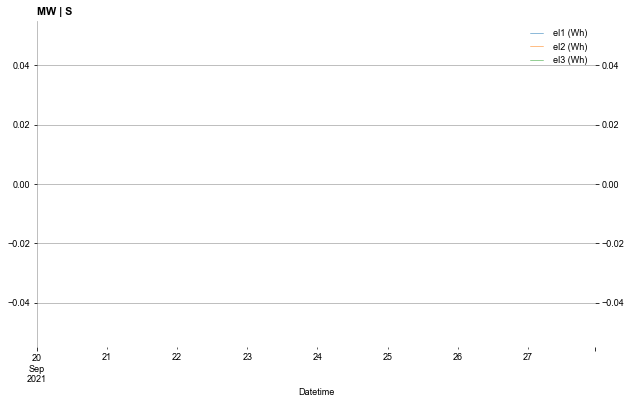

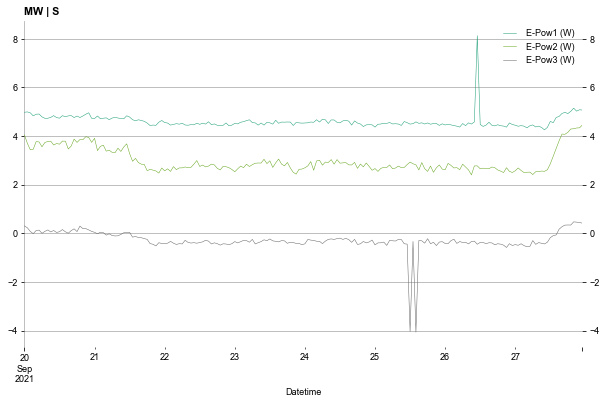

In [39]:
bui = 'MW'
app = 'S'

IND[bui][app].loc['2021-09'].filter(like='(W)').plot()
plt.ylim(-10,10)
plt.title(f'{bui} | {app}')

dfp = IND[bui][app][''].loc['2021-09-20':'2021-09-27'].filter(like='el').diff().resample('H').sum()
dfp = dfp[dfp > 0]
dfp.plot()
plt.title(f'{bui} | {app}')

IND[bui][app][''].loc['2021-09-20':'2021-09-27'].filter(like='(W)').resample('H').mean().plot(cmap='Dark2', label = 'Summe Stromkreise 1-3') #.sum(axis=1)

plt.title(f'{bui} | {app}')

## Auswertung Fensterkontakt, Bewegungsmelder und Stromverbrauch pro Wohneinheit
___
Mittelwerte über den Tagesverlauf, stündliche Auflösung

In [40]:
MDs = {}
WINs = {}
ELs = {}
path = os.path.join(eb.dir_results, 'Nutzungsverhalten')
if not os.path.exists(path): os.makedirs(path)

for color, bui in zip([ut.truncate_colormap('Greens_r',0, 0.6), ut.truncate_colormap('Oranges_r',0, 0.7), ut.truncate_colormap('Blues_r',0, 0.6)], eb.buid):    
    for app in ['S', 'N']:
        with PdfPages(os.path.join(path, f'{bui}_{app}_Vergleich_reed_md_el.pdf')) as pdf:
            for name, group in IND[bui][app].groupby([IND[bui][app].index.year, IND[bui][app].index.month]):
                for pl in ['mean']:
                    fig, axs = plt.subplots(7,1,figsize=style.din_a4)
                    fig.suptitle(f'{eb.buid[bui]} | {eb.wohnungen[app]} | {dt.datetime(name[0],name[1],1).strftime("%B %Y")}')

                    # Bewegunsmelder Wohnzimmer
                    ax = axs[0]
                    room = 'WZ'
                    dataset = (group[room].filter(like='_md').resample('H').sum())
                    if pl == 'mean':
                        n_max = 60/len(dataset.resample('D'))
                        dataset = dataset.groupby(dataset.index.hour).mean()
                        MDs[(bui, app, room)] = dataset.mean(axis=1)
                    elif pl == 'median':
                        dataset = dataset.groupby(dataset.index.hour).median()
                    dataset.plot.bar(ax=ax,cmap = color)
                    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False,labels=[f'{KOMPASS[col.split("_")[0]]}fassade' for col in dataset.columns])
                    #ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
                    ax.set_title(f'Bewegungsmelder Wohnzimmer')
                    ax.set_ylim(0,10)

                    # Fenster Wohnzimmer
                    ax = axs[4]
                    dataset = group[room].filter(like='_reed').replace(['Closed', 'Open'],[0,1]).resample('H').mean()
                    if pl == 'mean':
                        dataset = dataset.groupby(dataset.index.hour).mean()
                        labels=[]
                        for col in dataset.columns:
                            ori = KOMPASS[col.split('_')[0]]
                            size = re.search(r'\[(.*?)\]', col)[0]
                            labels.append(f"{ori} {size}")
                            WINs[(bui, app, room, col)] = dataset[col]
                    elif pl == 'median':
                        dataset = dataset.groupby(dataset.index.hour).median()
                    dataset.mul(100).plot.bar(ax=ax,cmap = color)
                    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
                    ax.set_title(f'Fenster Wohnzimmer')
                    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False,labels=labels)
                    ax.set_ylim(0,100)

                    # Bewegunsmelder Flur
                    ax = axs[1]
                    room = 'F'
                    dataset = (group[room].filter(like='_md').resample('H').sum())
                    
                    if pl == 'mean':
                        n_max = 60/len(dataset.resample('D'))
                        dataset = dataset.groupby(dataset.index.hour).mean()
                        MDs[(bui, app, room)] = dataset.mean(axis=1)
                    elif pl == 'median':
                        dataset = dataset.groupby(dataset.index.hour).median()
                    dataset.plot.bar(ax=ax,cmap = color)  
                    ax.legend(labels = [f'{KOMPASS[col.split("_")[0]]}fassade' for col in dataset.columns], loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                    #ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())          
                    ax.set_title(f'Bewegungsmelder Flur')
                    ax.set_ylim(0,10)

                    #Fenster Flur
                    ax = axs[2]
                    room = 'F'
                    dataset = group[room].filter(like='_reed').replace(['Closed', 'Open'],[0,1]).resample('H').mean()
                    if pl == 'mean':
                        dataset = dataset.groupby(dataset.index.hour).mean()
                        labels = []
                        for col in dataset.columns:
                            ori = KOMPASS[col.split('_')[0]]
                            size = re.search(r'\[(.*?)\]', col)[0]
                            labels.append(f"{ori} {size}")
                            WINs[(bui, app, room, col)] = dataset[col]
                    elif pl == 'median':
                        dataset = dataset.groupby(dataset.index.hour).median()
                    dataset.mul(100).plot.bar(ax=ax,cmap = color)
                    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
                    
                    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False,labels=labels)
                    ax.set_title(f'Fenster Flur')
                    ax.set_ylim(0,100)

                    #Fenster Küche
                    ax = axs[3]
                    room = 'K'
                    dataset = group[room].filter(like='_reed').replace(['Closed', 'Open'],[0,1]).resample('H').mean()
                    if pl == 'mean':
                        dataset = dataset.groupby(dataset.index.hour).mean()
                        labels=[]
                        for col in dataset.columns:
                            ori = KOMPASS[col.split('_')[0]]
                            size = re.search(r'\[(.*?)\]', col)[0]
                            labels.append(f"{ori} {size}")
                            WINs[(bui, app, room, col)] = dataset[col]
                    elif pl == 'median':
                        dataset = dataset.groupby(dataset.index.hour).median()

                    dataset.mul(100).plot.bar(ax=ax,cmap = color)
                    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
                    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False,labels=labels)
                    ax.set_title(f'Fenster Küche')
                    ax.set_ylim(0,100)

                    #Fenster Schlafzimmer
                    ax = axs[5]
                    room = 'SZ'
                    dataset = group[room].filter(like='_reed').replace(['Closed', 'Open'],[0,1]).resample('H').mean()   
                    if pl == 'mean':
                        dataset = dataset.groupby(dataset.index.hour).mean()
                        labels = []
                        for col in dataset.columns:
                            ori = KOMPASS[col.split('_')[0]]
                            size = re.search(r'\[(.*?)\]', col)[0]
                            labels.append(f"{ori} {size}")
                            WINs[(bui, app, room, col)] = dataset[col]
                    elif pl == 'median':
                        dataset = dataset.groupby(dataset.index.hour).median()   
                    dataset.mul(100).plot.bar(ax=ax,cmap = color)
                    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
                    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False,labels=labels)
                    ax.set_title(f'Fenster Schlafzimmer')
                    ax.set_ylim(0,100)

                    #Stromzähler
                    ax = axs[6]
                    room = ''
                    dataset = group[room].filter(like='(W)').abs().sum(axis=1).resample('H').mean()
                    if pl == 'mean':
                        dataset = dataset.groupby(dataset.index.hour).mean()
                        ELs[(bui, app, room)] = dataset
                    if pl == 'median':
                        dataset = dataset.groupby(dataset.index.hour).median()   
                    dataset.mul(100).plot.bar(ax=ax,cmap = color)
                    ax.set_title(f'Stromzähler')
                    ax.set_ylabel(f'Wh')
                    fig.tight_layout()
                    pdf.savefig(fig)
                    if ex:
                        plt.clf()
                if not ex:
                    break


<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<AxesSubplot:xlabel='Datetime'>

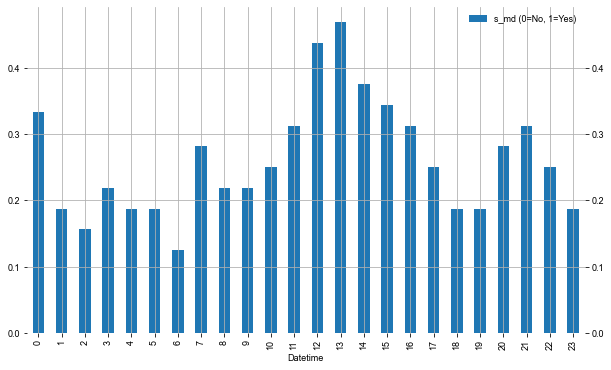

In [48]:
df = (IND['MW']['S']['WZ'].filter(like='_md').resample('30min').max()).loc['2022-02']
df.groupby(df.index.hour).mean().plot.bar()


## Auswertung Bewegungsmelder, Fensterkontakt und Stromverbrauch pro Raum
___
Stündliche Darstellung

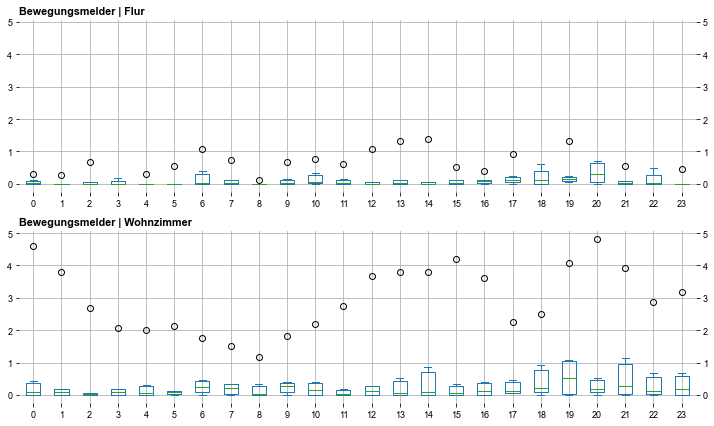

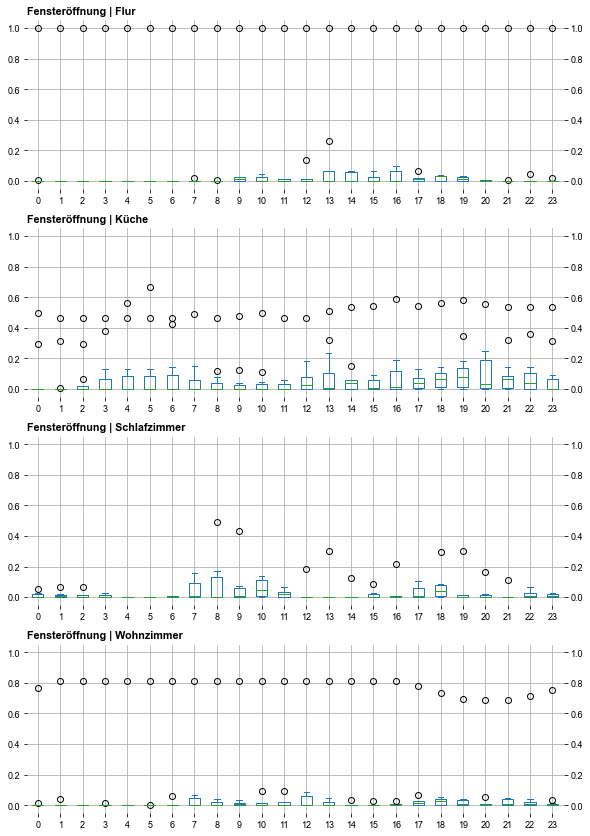

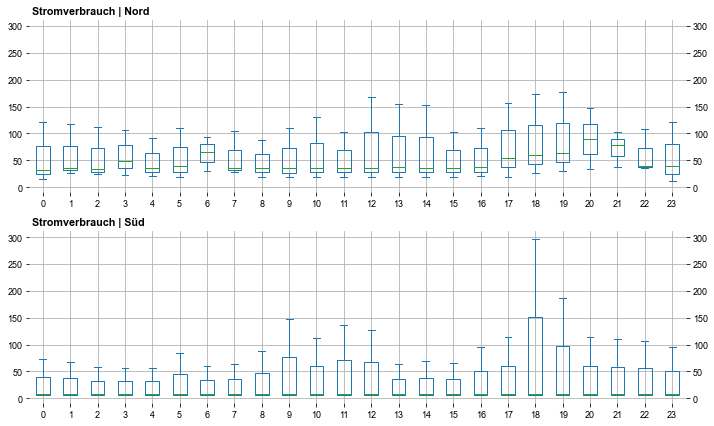

In [42]:
with PdfPages(os.path.join(path, 'Boxplots.pdf')) as pdf:
    df = pd.DataFrame(MDs).T.dropna(how='all').groupby(level=2)
    n = len(df.groups)
    fig, axs = plt.subplots(n,1, sharey=True)
    for i, (name, group) in enumerate(df):
        ax = axs[i]
        group.plot.box(ax=ax)
        ax.set_title(f'Bewegungsmelder | {eb.rooms[name]}')
    fig.tight_layout()
    pdf.savefig(fig)

    df = pd.DataFrame(WINs).T.dropna(how='all').groupby(level=2)
    n = len(df.groups)
    fig, axs = plt.subplots(n,1, figsize = style.din_a4, sharey=True)
    for i, (name, group) in enumerate(df):
        ax = axs[i]
        group.plot.box(ax=ax)
        ax.set_title(f'Fensteröffnung | {eb.rooms[name]}')
    fig.tight_layout()
    pdf.savefig(fig)

    df = pd.DataFrame(ELs).T.dropna(how='all').groupby(level=1)
    n = len(df.groups)
    fig, axs = plt.subplots(n,1, sharey=True)
    for i, (name, group) in enumerate(df):
        ax = axs[i]
        group.plot.box(ax=ax)
        ax.set_title(f' Stromverbrauch | {eb.wohnungen[name]}')
    fig.tight_layout()
    pdf.savefig(fig)

## Auswertung Bewegunsmelder, Fensteröffnung, Stromverbrauch
____
gemittelt über alle Räume, Wohnungen und Häuser - stündliche Darstellung

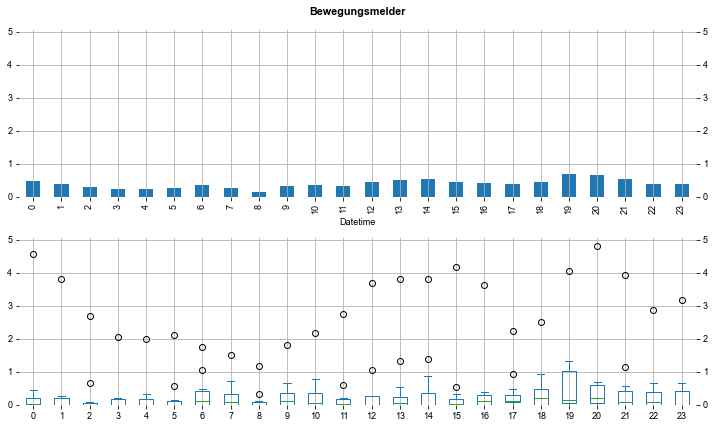

In [43]:
df = pd.DataFrame(MDs)
df = df.dropna(axis=1, how='all')

fig, axs = plt.subplots(2,1, sharey=True)
fig.suptitle('Bewegungsmelder')
df.T.mean().plot.bar(ax=axs[0],)
df.T.plot.box(ax=axs[1],)
fig.tight_layout()

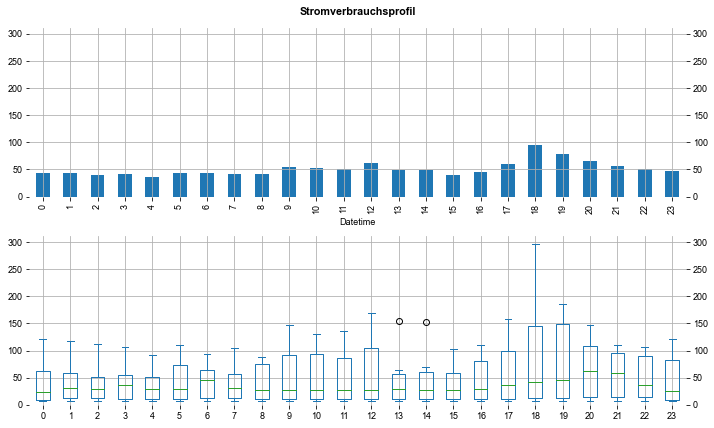

In [44]:
df = pd.DataFrame(ELs)
df = df.dropna(axis=1, how='all')

fig, axs = plt.subplots(2,1, sharey=True)
fig.suptitle('Stromverbrauchsprofil')
df.T.mean().plot.bar(ax=axs[0],)
df.T.plot.box(ax=axs[1],)
fig.tight_layout()

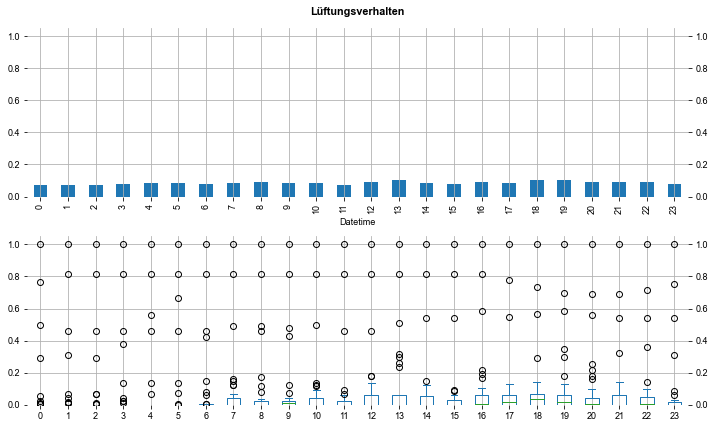

In [45]:
df = pd.DataFrame(WINs)
df = df.dropna(axis=1, how='all')

fig, axs = plt.subplots(2,1, sharey=True)
fig.suptitle('Lüftungsverhalten')
df.T.mean().plot.bar(ax=axs[0],)
df.T.plot.box(ax=axs[1],)
fig.tight_layout()

## Auswertung mittlerer monatlicher Stromverbrauch pro Wohnung
___
monatliche Darstellung

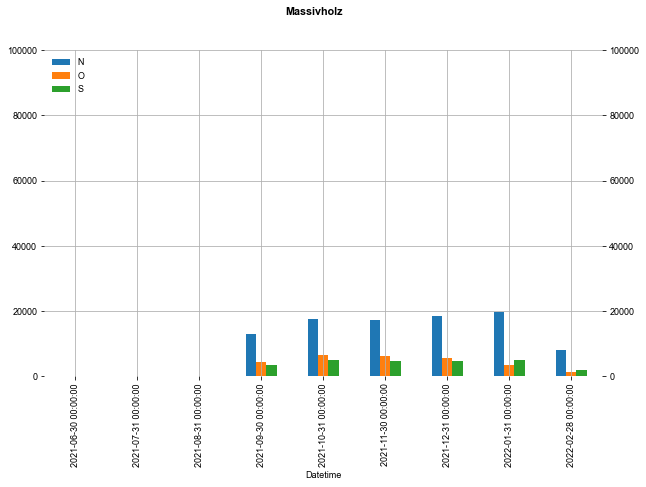

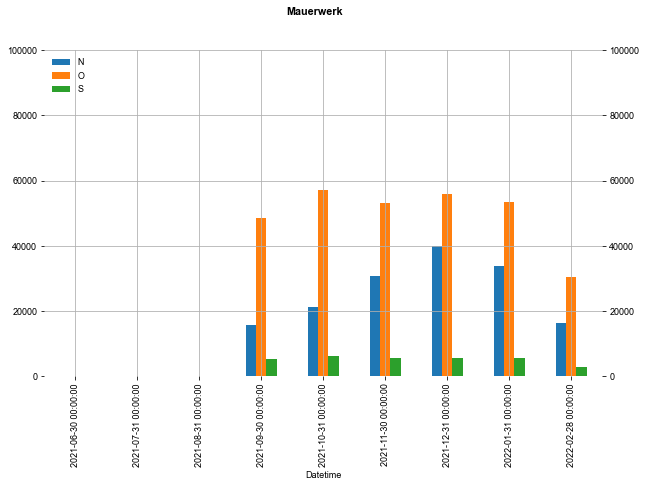

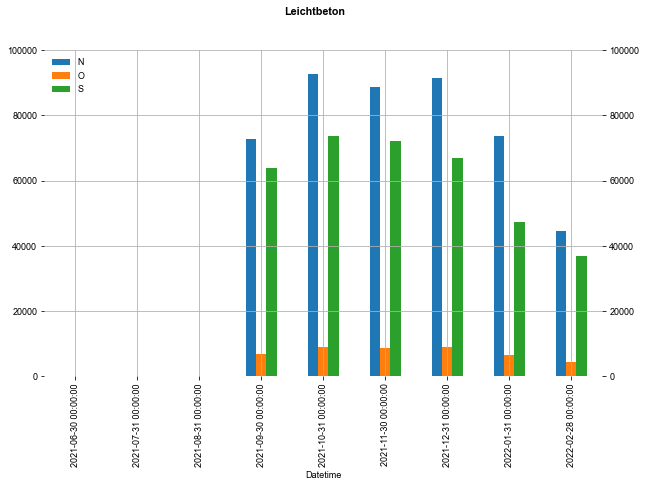

In [46]:
for color, bui in zip(['summer', 'autumn', 'winter'], eb.buid):
    fig, ax = plt.subplots()
    fig.suptitle(f'{eb.buid[bui]}')
    dataset = IND[bui].filter(like='(W)').abs().groupby(axis=1,level=0).sum().resample('min').last().resample('H').mean().resample('M').sum()
    dataset.plot.bar(ax=ax, label = [f'{bui}_{col}' for col in dataset.columns])
    ax.set_ylim(0,100000)
    ax.legend()